https://www.bilibili.com/video/BV1K64y1Q7wu?p=3&spm_id_from=pageDriver

# 正文

## 数据

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

第一次运行上面的加载数据，会显示
```bash
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz
HBox(children=(FloatProgress(value=1.0, bar_style='info', max=1.0), HTML(value='')))
```

+ fashion_mnist中的每个图像长和宽都是28px，通道数为1，所以shape是(1,28,28),因为softmax回归接受的输入要求是一个向量，所以需要把每个图像压平，将其视为长度为784的向量，
+ 拉成一个平的向量会丢失很多空间信息，这些就交给CNN卷积神经网络去搞就好了
+ 因为这个fashion_mnist是一个服装分类数据集，有10个类别，所以网络最后的输出维度是10

In [2]:
num_inputs=784
num_outputs=10

# 均值和标准差 不是方差
W=torch.normal(mean=0,std=0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)

定义完数据之后，可以定义模型/softmax操作了，在这里先回顾一下元素求和的操作

In [3]:
X=torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(0,keepdim=True),X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax

$$
softmax(\textbf X)_{ij}=\frac{exp(\textbf X_{ij})}{\sum_k{exp(\textbf X_{ik})}}
$$

我们现在已经准备好[**实现softmax**]操作了。回想一下，softmax 由三个步骤组成：
（1）对每个项求幂（使用`exp`）；
（2）对每一行求和（小批量中每个样本是一行），得到每个样本的归一化常数；
（3）将每一行除以其归一化常数，确保结果的和为1。
在查看代码之前，让我们回顾一下这个表达式：

(**
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
**)

分母或归一化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。该名称的起源来自 [统计物理学](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))中一个模拟粒子群分布的方程。

## softmax

In [4]:
def softmax(X):
    """
    这里注意，X不是一个行向量，而是一个矩阵，其中一行是一次送入softmax计算的数据
    """
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition  # 这里应用了广播机制

## 实现softmax回归模型（建模/目标函数）

y=softmax(ax+b)

在线性回归模型外面套一层softmax函数，就是softmax回归模型了，用来解决分类问题

In [5]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W) + b)

这里 `X.reshape(-1, W.shape[0])`中
+ -1的意思是我不计算，让程序自动帮我算，
+ W.shape[0]是num_inputs，也就是28\*28=784
+ 实际上第一维应该是bacth_size,最后应该是等于上面规定的256

## 交叉熵函数（损失函数，求解目标函数）

交叉熵常用来衡量两个概率的区别：
$$\textbf H(\textbf{p},\textbf{q})=\sum_{i}{-p_ilog(q_i)}$$

将其作为损失函数，可以表示为：
$$ l(\textbf{y},\hat{\textbf{y}}) =-\sum_i{y_ilog\hat{y}_i}=-log\hat{y}_y$$

其梯度是真实概率和预测概率的区别：
$$\partial _{o_i}l(\textbf{y},\hat{\textbf y}) =softmax(o)_i-y_i$$


这里有个推导问题，咋样就导数就成这样了。

In [6]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

举个例子看就比较好理解了

In [7]:
y=torch.tensor([0,2])
# y表示有两个样本，第一个样本的真实类别是第0类，第二个样本的真实类别是第2类
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])

In [8]:
a=y_hat[range(len(y_hat)),y]
# 这里其实就是切片，range(len(y_hat))得到[0,1] y=[0,2]
# 所以从y_hat中取的两个值是 [0,0]和[1,2] (range(len(y_hat)))是找出所有样本的行数，
# y则是真实标记，但是这里真实标记并没有被转换为one-hot，而是每个样本一个数值，两个样本就是一个含有两个元素的向量。
# 和上面导数最后推导出的结果一致
print(a,len(y_hat))

tensor([0.1000, 0.5000]) 2


In [9]:
cross_entropy(y_hat,y),cross_entropy(y_hat,y)*2

(tensor([2.3026, 0.6931]), tensor([4.6052, 1.3863]))

> +  上面这个只是损失函数，可以帮助我们找到最终要优化的参数，也就是求解模型，但是这不足以描述模型的好坏，所以还要再创建一个指标来描述这个模型最后的一个性能/表现。
> + 就好像之前CV领域训练的时候可以看到loss下降，但是还是要经过数据集验证，找一些该场景的指标去看模型的效果
> + loss是评价这个模型找出的参数对当前数据集是否合适，后续在其他数据集上的验证指标才是更有利的评价标准

## 计算准确率

In [10]:
def accuracy(y_hat,y):
    """
    计算预测正确数量
    """
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:  
        # 对于一个真实的test场景，test样本肯定不止一个，
        # 所以y_hat一定是多行，另外，对于分类问题，y_hat的每行长度一定大于1，y_hat.shape[1]>1 ，所以y_hat.shape>1
        # 目前看来，多个样本的y_hat一定是一个二维矩阵？？？ axis=1 就是找出每行的最大值（最大概率值） argmax，找出最大值对应的下标
        # 返回到y_hat y_hat变成了一个一维向量
        y_hat=y_hat.argmax(axis=1)
        # 数据类型可能不一样，所以要转换一下 然后判断是否相等 == （预测的类别是否就是真实的类别，不考虑预测的概率值的差距，只要错了就是不对。。）
        cmp=y_hat.type(y.dtype)==y
        return float(cmp.type(y.dtype).sum()) 

In [11]:
y_hat_argmax=y_hat.argmax(axis=1)
print(y_hat_argmax)

tensor([2, 2])


In [12]:
cmp=y_hat_argmax.type(y.dtype)==y
print(cmp)

tensor([False,  True])


In [13]:
y.dtype

torch.int64

In [14]:
cmp.sum().tolist(),cmp.type(y.dtype)

(1, tensor([0, 1]))

In [15]:
float(cmp.type(y.dtype).sum())

1.0

In [16]:
accuracy(y_hat,y)/ len(y)
# 所以最后正确预测的比例是
# 两个样本，对了一个，错了一个

0.5

同样，对于任意数据迭代器 `data_iter` 可访问的数据集，[**我们可以评估在任意模型 `net` 的准确率**]。

In [17]:
def evaluate_accuracy(net,data_iter):
    """
    计算在指定数据集上模型的精度
    """
    if isinstance(net,torch.nn.Module):
        net.eval()  # 将模型设置为评估模式，不进行梯度计算,只用进行forward pass
    metric=Accumulator(2)   # 正确预测数，预测总数 后面会定义这个函数 是一个累加器
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

+ 这是因为不是每个批次数据个数都相同，最后一个批次的数据可能凑不满256.
+ 不直接准确率总和除以样本数量，是因为这个函数在每个批次训练完之后都要打印输出，进行观察的。

In [18]:
a=torch.zeros((3,4))
print(a,a.numel(),a.size().numel())
# 这个numel返回最内侧数值的个数

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) 12 12


In [19]:
class Accumulator:
    """ 对多个变量进行累加"""
    def __init__(self,n):
        self.data=[0.0]*n  # 扩展成一个n维度的浮点数0向量
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

In [20]:
for a,b in zip([0.0,0.0],(0.5,1)):
    print(a,b)
# 对应 基础变量和该变量的增量

0.0 0.5
0.0 1


In [21]:
evaluate_accuracy(net,test_iter)

0.1493

这个问题是一个10分类问题，使用FASHION_MNIST的测试数据，在没有训练的情况下，可以看到这个准确率也基本上是随机的，差不多约等于十分之一

In [22]:
[0.0]*3,torch.zeros(3)
# 效果看起来差不多？？？

([0.0, 0.0, 0.0], tensor([0., 0., 0.]))

关于 `self.data=[a+float(b) for a,b in zip(self.data,args)]`，在这个例子中，数据变换如下：
+ `metirc=Accumulator(2)`时,`self.data=[0.0,0.0]`
+ 然后在`for X,y in data_iter`的循环中，执行了add函数，此时，`for a,b in zip(self.data,args)`，`args`中含有两个值，`args=[accuracy(预测准确的样本个数，是个数，没有/len(y)),y.numel()]`,args中包含了当前data_iter中正确预测的样本个数以及所有的样本个数

## softmax回归的训练

一个epoch中的所有batch_size，这里是训练一轮的函数。

后面规定epoch次数，调用这个函数即可

In [6]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train() # 开启训练模式
    metric=Accumulator(3) # 累加器要负责监控三个变量的累加情况
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y) # 返回的l是一个向量 多少个样本 l就是含有多少元素的一维向量
     # loss是一个参数，cross_entropy会作为实参传进来
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            print(f"loss经过backward之后的结果：{l}")
            # 不理解下面的float(l)*len(y) 这里打印一下 看看
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
            # 这里更新的三个累加量和上面差不多，这里的l不再是单纯的crosss_entropy得到的一个含有样本个元素的向量了，
        else:
            # 如果没有给优化器，就自己搞一个最简单的
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]  

## 定义动画绘制类

定义一个在动画中绘制数据的实用程序类

In [24]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 训练函数

整合上面softmax回归的训练和绘制图像函数

In [25]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 得到训练损失和准确率
        test_acc = evaluate_accuracy(net, test_iter)
        # 得到测试集上的准确率（不是正确预测的样本个数，除过y.numel()了）
        animator.add(epoch + 1, train_metrics + (test_acc,))
        # 画图，不仅显示训练集情况，也显示测试集的情况
    train_loss, train_acc = train_metrics
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 优化器

### 自定义优化器

In [26]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

关于自定的这个sgd函数，其原型是：
```python
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
```

# ✅实际用到的所有训练代码

In [39]:
import torch
from IPython import display
from d2l import torch as d2l

# 数据加载
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

# 训练参数定义
num_inputs=784
num_outputs=10

W=torch.normal(mean=0,std=0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)

# 建模 先定义softmax 因为模型要用 使用softmax进行分类
def softmax(X):
    """
    这里注意，X不是一个行向量，而是一个矩阵，其中一行是一次送入softmax计算的数据
    """
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition  # 这里应用了广播机制

def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W) + b)

# 定义损失函数
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

# 准确率和批次准确率
def accuracy(y_hat,y):
    """
    计算预测正确数量
    """
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:  
        y_hat=y_hat.argmax(axis=1)
        cmp=y_hat.type(y.dtype)==y
        return float(cmp.type(y.dtype).sum()) 

class Accumulator:
    """ 对多个变量进行累加"""
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
    
def evaluate_accuracy(net,data_iter):
    """
    计算在指定数据集上模型的精度
    """
    if isinstance(net,torch.nn.Module):
        net.eval() 
    metric=Accumulator(2)  
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric=Accumulator(3) 
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y) 
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
#             print(f"loss经过backward之后的结果：{l}")
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]  

class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
# 整个训练过程

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    
# 自定义优化器
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

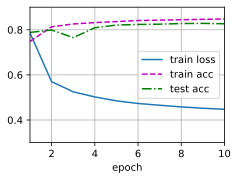

In [3]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,updater)
# 这里其实有个很好玩的事情，这里的cross_entropy 和updater 都是函数，但是传进去的都只有函数名字

上面这个确实会动，应该就是运行完一个batch_size的训练，就重新画一个，所以视觉上就像动画一样

+ 另外，遇到一个很奇怪的事情，一模一样的代码，我在过程中曾经将`y.size().numel()`变成了`y.numel()`，一开始就一直报错，后面换回size，不报错了，再换回没有size，也不报错了，重启再次运行。
+ 同时，根据弹幕反馈，似乎有人图出不来。。。
+ 可能确实存在一些问题

In [28]:
for X,y in train_iter:
#     print(y.numel(),y.size().numel())
    print(y.numpy())
    break

[9 6 3 9 9 5 6 3 3 7 3 4 8 7 5 9 5 3 9 0 3 6 2 5 7 1 2 3 6 9 8 2 0 7 2 1 2
 2 7 5 0 4 9 1 0 7 3 4 2 2 1 9 8 1 2 7 0 3 5 5 5 3 3 0 3 4 0 4 7 4 0 8 7 3
 4 3 1 1 5 9 0 5 7 4 1 4 3 5 6 0 9 6 5 0 5 0 4 1 5 7 7 0 0 8 7 0 1 1 1 6 1
 7 1 4 1 7 1 6 5 8 9 9 2 3 6 9 1 3 8 1 1 6 3 0 1 2 4 2 2 4 4 9 1 3 0 6 0 2
 4 8 7 0 3 9 2 9 0 9 3 4 5 4 7 0 0 1 4 4 2 5 1 1 5 4 2 0 2 8 9 9 9 0 9 6 0
 2 5 8 7 1 9 6 0 5 8 0 5 6 1 5 7 5 6 9 0 2 9 3 2 3 8 6 1 9 6 2 8 4 7 5 3 2
 8 1 3 5 1 5 2 1 1 4 2 9 8 3 9 5 5 9 0 2 7 1 3 5 3 6 7 1 4 2 7 6 9 1]


可以看到，y（真实值）就是每个样本对应的类别的数字，只有一个数字，不是one-hot表示的

## 尝试调整参数，看看

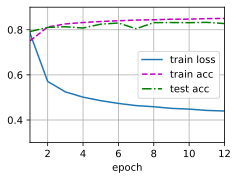

In [11]:
lr = 0.1
num_epochs = 12
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,updater)

## pytorch内置优化器

### 💢个人探索

In [4]:
isinstance(updater,torch.optim.Optimizer)
# 可以看到，这里其实使用的是自定义的updater，所以没有执行到上面

False

修改优化器，看是否可以执行到上面我疑惑的地方，发现报错，这里代码是有问题的，暂时放弃

In [19]:
optimizer = torch.optim.SGD([W,b], lr = 0.1, momentum = 0)
isinstance(optimizer,torch.optim.Optimizer)

True

一开始下面的运行报错：
+ `RuntimeError: grad can be implicitly created only for scalar outputs`
+ ---> 73             l.backward()

经过比较，发现使用pytorch自带的优化器和使用自定义优化器，代码部分差距主要体现在,一个l进行了sum()，一个没有:
```python
if isinstance(updater,torch.optim.Optimizer):
    updater.zero_grad()
    l.backward()
    print(f"loss经过backward之后的结果：{l}")
    updater.step()
    metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
else:
    l.sum().backward()
    updater(X.shape[0])
    metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
```
+ 对使用自带的优化器代码加上，l.sum()或者是l.mean()，然后再运行,
+ 另外，由于`metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())`这里也需要改，所以直接使用mean，`(float(l.mean())`

整体改为：
```python
if isinstance(updater,torch.optim.Optimizer):
    updater.zero_grad()
    l.mean().backward()
    print(f"loss经过backward之后的结果：{l}")
    updater.step()
    metric.add(float(l.mean())*len(y),accuracy(y_hat,y),y.size().numel())
```

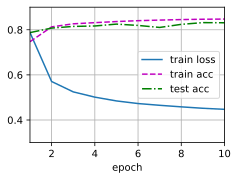

In [20]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, optimizer)

### ✅查看官方论坛

参考：[3. 线性神经网络》3.6. softmax回归的从零开始实现](https://zh-v2.d2l.ai/chapter_linear-networks/softmax-regression-scratch.html)

chenck:
1.计算训练损失要乘上len(y)，是因为pytorch会自动对loss取均值？

Yes. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

+ 所以如果要使用pytorch自带的优化器，那么损失函数也要调用官方的，如下，按照上面网页文档最下面的示例使用就对了
+ 而且观察不难发现

In [41]:
optimizer = torch.optim.SGD([W,b], lr = 0.01, momentum = 0.05)
isinstance(optimizer,torch.optim.Optimizer)

True

AssertionError: 1.8784832507451374

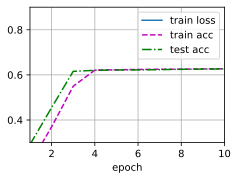

In [42]:
loss = torch.nn.CrossEntropyLoss()
train_ch3(net, train_iter, test_iter, loss, num_epochs,optimizer)

使用自带的损失函数和自带的优化器，
+ lr=0.1,momentum=0,结果损失似乎太大了。报错了。。 assertation 错误，train_loss=2.3XXX，大于0.5了
+ 调整了一下参数，lr=0.01,momentum=0.05，然后才画出图来。。。
+ 训练完对比一下，好奇怪，还没自己随便写的结果好。。。

## 分类预测

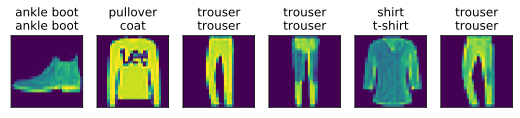

In [43]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

可以看到，准确率还是挺高的，基本都是对的

# 扩展知识

## 验证softmax

In [44]:
a=torch.tensor([[1.,2.,3.],[2.,2.,3.]])
a_exp=torch.exp(a)
print(f"exp之后的结果为: {a_exp}")
# 注意 exp操作针对的必须是浮点数

a_exp_sum=a_exp.sum(1,keepdim=True)
print(f"exp并sum之后的结果为：{a_exp_sum}")

softmax_rs=a_exp/a_exp_sum
print(f"softmax的结果为：{softmax_rs}")

softmax_rs_broadcast= torch.div(a_exp,a_exp_sum)
print(f"广播后的softmax结果：{softmax_rs_broadcast}")

exp之后的结果为: tensor([[ 2.7183,  7.3891, 20.0855],
        [ 7.3891,  7.3891, 20.0855]])
exp并sum之后的结果为：tensor([[30.1929],
        [34.8636]])
softmax的结果为：tensor([[0.0900, 0.2447, 0.6652],
        [0.2119, 0.2119, 0.5761]])
广播后的softmax结果：tensor([[0.0900, 0.2447, 0.6652],
        [0.2119, 0.2119, 0.5761]])


In [45]:
softmax(a)

tensor([[0.0900, 0.2447, 0.6652],
        [0.2119, 0.2119, 0.5761]])

In [46]:
from torch import nn
m = nn.Softmax(dim=1)
# dimb表示要沿着计算的轴
input = torch.randn(2, 3)
output = m(input)
print(input)
print(output)

tensor([[-0.2796,  0.4576, -1.5735],
        [ 0.3897,  0.6239,  0.4454]])
tensor([[0.2972, 0.6213, 0.0815],
        [0.3011, 0.3805, 0.3183]])


另外，一般看都是看每个样本输出结果是不是一个和为1的向量，并不像我上面那样是为了看清楚计算的意义

In [47]:
X=torch.normal(0,1,(2,5))
# 均值为0，标注差为1的2*5 2个样本，5个类别的矩阵
X_prob=softmax(X)
print(X_prob)
print(X_prob.sum(1))

tensor([[0.2218, 0.0676, 0.2057, 0.2690, 0.2358],
        [0.1867, 0.4202, 0.2825, 0.0214, 0.0892]])
tensor([1., 1.])


注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 交叉熵函数前置复习

下面，我们[**创建一个数据`y_hat`，其中包含2个样本在3个类别的预测概率，**]它们对应的标签`y`。
有了`y`，我们知道在第一个样本中，第一类是正确的预测，而在第二个样本中，第三类是正确的预测。
然后(**使用`y`作为`y_hat`中概率的索引**)，我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。

简单来说，拿出预测的概率序列中真实标号对应的那个概率值

In [48]:
y=torch.tensor([0,2])
# y表示有两个样本，第一个样本的真实类别是第0类，第二个样本的真实类别是第2类
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]
# 则取出softmax结果中对应序号，则就是训练出的对应的y_hat，在这个基础上，送入交叉熵损失函数，进行优化。

tensor([0.1000, 0.5000])

    y_hat[[0,1],[0,2]]
    # 这个直接就是数字索引
    # 找的其实是0,0和1,2这两个位置的值

In [49]:
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

这里注意，虽然这个交叉熵损失不是 真实值-预测值 让差距最小，但是它输出的是每个样本属于某个类的概率，目标是让概率值最大（加上-log之后，就是让这个值最小。）

+ MSE使用的是差值，让差值最小，每个样本都有真实值和预测值的差值
+ 同理，cross_entropy使用的是概率，让概率最大/最大，每个样本都对应一个概率值。

In [50]:
import numpy as np

a=np.array([[0.1,0.3,0.6],[0.3,0.2,0.5]])
a[[0,1],[0,2]]
# 注意，这里的index没有： 冒号，所以上面a[[0,1,[0,2]]的写法就相当于a[0,0]和a[1,2] 

array([0.1, 0.5])